In [133]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import timeit
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import xesmf as xe
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import calendar

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data


import dask
from dask.distributed import Client


# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
#client = Client(n_workers=8)
#client

In [135]:
# Plotting Info
runType = 'forecast'
variables = ['sic']
metrics_all = {'sic':['SIP']}
metric='SIP'

### Time configuration

In [4]:
# SIO Report Year_Month
cyear = '2019'
cmonth = 'June'
#cmonth = 'July'
#cmonth = 'August'

# Target time range
valid_start = np.datetime64('2019-09-01')
valid_end = np.datetime64('2019-09-30')


month_cal=dict((v,k) for k,v in enumerate(calendar.month_abbr))
date_str = pd.to_datetime(datetime.datetime(int(cyear), month_cal[cmonth[0:3]], 1)).strftime('%Y-%m-%d')
itstr = date_str
itstr
r_yr_mon = cyear+'_'+cmonth

mon_2_int = {v: k for k,v in enumerate(calendar.month_name)}



In [5]:
# Define custom mod names, okay if not used
# https://docs.google.com/document/d/1eztVwPllCKDYOXbZ4nBt3j-3aK3YeOfAf6TPSb-86fQ/edit 
custom_names = {'usnavysipn':'Navy ESPC','gfdlsipn':'NOAA GFDL','noaasipn':'NCEP CPC','uclsipn':'UCL',
                'ukmetofficesipn':'Met. Office','ecmwfsipn':'ECMWF-c3s',
                'gmao':'NASA GMAO','seansipn':'NSIDC,\nCU Boulder', 'piomas':'UW APL',
                'awispin':'AWI\nConsortium','szapirosipn':'MPAS-CESM',
                'nmisipn':'Norwegian\nMet. Inst.','fgoalssipn':'IAP LASG',
                'nicosipn':'Sun','Xiaojun':'Lamont','modcansipns_4':'Modified\nCanSIPS'}
if cmonth == 'August':
    custom_names['gmao'] = 'NASA Sewnath'

custom_names

{'Xiaojun': 'Lamont',
 'awispin': 'AWI\nConsortium',
 'ecmwfsipn': 'ECMWF-c3s',
 'fgoalssipn': 'IAP LASG',
 'gfdlsipn': 'NOAA GFDL',
 'gmao': 'NASA GMAO',
 'modcansipns_4': 'Modified\nCanSIPS',
 'nicosipn': 'Sun',
 'nmisipn': 'Norwegian\nMet. Inst.',
 'noaasipn': 'NCEP CPC',
 'piomas': 'UW APL',
 'seansipn': 'NSIDC,\nCU Boulder',
 'szapirosipn': 'MPAS-CESM',
 'uclsipn': 'UCL',
 'ukmetofficesipn': 'Met. Office',
 'usnavysipn': 'Navy ESPC'}

In [6]:
E = ed.EsioData.load()
# Define fig dir and make if doesn't exist
fig_dir = os.path.join(E.fig_dir, 'model', 'SIO_Reports', cyear, cmonth)
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
print('fig dir is ',fig_dir)


# Define models to plot and not to plot
No_No_models = ['MME_NEW','piomas','MME','modcansipns_3','modcansipns_4','ecmwfsipn','usnavygofs',
                   'szapirosipn','noaasipn_ext','rasmesrl','uclsipn','noaasipn','yopp','nicosipn']
non_SIPN_Report_models  = ['ecmwf','ukmo','kma','ncep','usnavyncep','metreofr','dampedAnomalyTrend'] # Models like s2s
models_2_plot = list(E.model.keys())
models_2_plot = [x for x in models_2_plot if np.any(x not in No_No_models) ] # remove some models
models_2_plot = [x for x in models_2_plot if np.any(x not in non_SIPN_Report_models) ] # remove some more models
models_2_plot = [x for x in models_2_plot if E.icePredicted[x]] # Only predictive models

# no data in august at all
#if r_yr_mon=='2019_August':
#    models_2_plot = [x for x in models_2_plot if np.any(x not in ['fgoalssipn']) ] # remove some models
MME_NO = []
models_2_plot


fig dir is  /home/disk/sipn/nicway/public_html/sipn/figures/model/SIO_Reports/2019/June


['gfdlsipn',
 'ukmetofficesipn',
 'meteofrsipn',
 'usnavysipn',
 'awispin',
 'fgoalssipn']

In [7]:
# Get recent observations
ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True)


da_obs = ds_81.sic.sel(time=slice(valid_start, valid_end))
da_obs_SIP = (da_obs>= 0.15).mean(dim='time').where(da_obs.isel(time=0).notnull())
#da_obs_edge = (da_obs_SIP>= 0.5).astype('int')
da_obs_SIP

<xarray.DataArray 'sic' (y: 448, x: 304)>
dask.array<shape=(448, 304), dtype=float64, chunksize=(448, 304)>
Coordinates:
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
    hole_mask  (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    lat        (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon        (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm         (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym         (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    time       datetime64[ns] 2019-09-01

### Load in User submited SIP data

In [8]:
have_data = True  

In [9]:
if have_data:
    # Load in last results
    ds_SIP_All = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/SIO/'+cyear+'/'+cmonth+'/SIP.nc').SIP

    print(ds_SIP_All)
    
ds_SIP_All = ds_SIP_All.where(ds_SIP_All.isel(model=0).notnull(),other = np.nan)
ds_MME_avg = ds_SIP_All.mean(dim='model')
ds_MME_std = ds_SIP_All.std(dim='model')


<xarray.DataArray 'SIP' (model: 12, x: 304, y: 448)>
dask.array<shape=(12, 304, 448), dtype=float64, chunksize=(12, 304, 448)>
Coordinates:
    lon        (x, y) float64 dask.array<shape=(304, 448), chunksize=(304, 448)>
    lat        (x, y) float64 dask.array<shape=(304, 448), chunksize=(304, 448)>
  * model      (model) object 'gfdlsipn' 'ukmetofficesipn' ... 'nicosipn'
    init_date  (model) datetime64[ns] dask.array<shape=(12,), chunksize=(12,)>
Dimensions without coordinates: x, y


In [10]:
f_in ='/home/disk/sipn/nicway/data/model/climo10yrs/forecast/metrics/climoSIP_SIC_2018_to_nextyear.nc'
climo = xr.open_mfdataset(f_in).SIP  # times are end of period so shift valid period by 3 days
vstart = np.datetime64('2019-09-01')
vend = np.datetime64('2019-10-01')
climo = climo.sel(init_end=slice(vstart,vend)).mean(dim='init_end')

In [11]:
def get_plot_title(cmod, custom_names, E):
    if cmod in custom_names:
        new_title = custom_names[cmod]
    elif cmod in E.model.keys():
        new_title = E.model[cmod]['model_label']
    else:
        new_title = cmod
    return new_title

def add_subplot_title(cmod, custom_names, E, ax=None):
    ax.set_title(get_plot_title(cmod, custom_names, E))


In [12]:
        
# Set up plotting info
cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
#cmap_c = plt.get_cmap('jet') 
cmap_c.set_bad(color = 'lightgrey')

cmap_diff = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","white","red",])
cmap_diff.set_bad(color = 'lightgrey')

c_label = 'Sea Ice Probability (-)'
c_vmin = 0
c_vmax = 1

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


Text(0.5,1,'Observed')

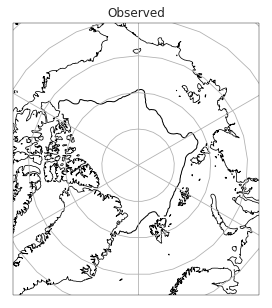

In [14]:
# TEST 
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1

(f, axes) = ice_plot.polar_axis(extent=central_extent, central_longitude=0)


po = da_obs_SIP.plot.contour(ax=axes, x='xm', y='ym',
                              transform=ccrs.NorthPolarStereo(central_longitude=-45),
                              colors=('k'),
                              linewidths=[1],levels=[0.5]) 
#ice_plot.remove_small_contours(po, thres=10**6)


axes.set_title('Observed')


gfdlsipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


ukmetofficesipn
usnavysipn
awispin
modcansipns_4
gmao
fgoalssipn
piomas
nmisipn
seansipn
Xiaojun
nicosipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n


saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/SIO_Reports/2019/June/panArctic_SIP_forecast_2019_June_lowRES_POSTSEASON.png


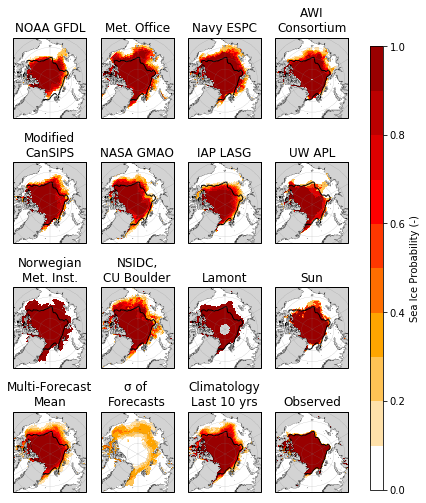

In [15]:
# New Plot
if cmonth=='August':
    NPLOTS = 17
elif cmonth=='July':
    NPLOTS = 17
else: 
    NPLOTS = 17
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=4, Nplots=NPLOTS, extent=central_extent, central_longitude=0)

for (i, cmod) in enumerate(ds_SIP_All.model.values):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    p = ds_SIP_All.sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)
    po = da_obs_SIP.plot.contour(ax=axes[i], x='xm', y='ym',
                              transform=ccrs.NorthPolarStereo(central_longitude=-45),
                              colors=('k'),
                              linewidths=[1],levels=[0.5]) 

    add_subplot_title(cmod, custom_names, E, ax=axes[i])
 

# MME Mean
i = i + 1

pmme = ds_MME_avg.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
po = da_obs_SIP.plot.contour(ax=axes[i], x='xm', y='ym',
                          transform=ccrs.NorthPolarStereo(central_longitude=-45),
                          colors=('k'),
                          linewidths=[1],levels=[0.5]) 

axes[i].set_title('Multi-Forecast\nMean')


# MME Standard deviation
i = i + 1


pmme = ds_MME_std.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('σ of \nForecasts')
    

# Climo10yrs
i = i + 1

pmme = climo.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)

po = da_obs_SIP.plot.contour(ax=axes[i], x='xm', y='ym',
                          transform=ccrs.NorthPolarStereo(central_longitude=-45),
                          colors=('k'),
                          linewidths=[1],levels=[0.5]) 

axes[i].set_title('Climatology\nLast 10 yrs')

   
# obs
i = i + 1

pmme = da_obs_SIP.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
po = da_obs_SIP.plot.contour(ax=axes[i], x='xm', y='ym',
                          transform=ccrs.NorthPolarStereo(central_longitude=-45),
                          colors=('k'),
                          linewidths=[1],levels=[0.5]) 


axes[i].set_title('Observed')



# Make pretty
f.subplots_adjust(bottom=0.05)
cbar_ax = f.add_axes([0.95, 0.075, 0.03, 0.77])
#cbar_ax = f.add_axes([0.14, 0.22, .75, 0.025]) #  [left, bottom, width, height] w
if p:
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='vertical')
#    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
    cbar.set_ticks(np.arange(0,1.1,0.2))
    
# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_POSTSEASON.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_lowRES_POSTSEASON.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)

## Now plot BSS

In [16]:
# Force round off lat/lon differences to be the same
da_obs_SIP['lat'] = ds_SIP_All.lat
da_obs_SIP['lon'] = ds_SIP_All.lon

# Load in regional data
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))

ds_region['lat'] = ds_SIP_All.lat
ds_region['lon'] = ds_SIP_All.lon


In [17]:
# Mask only to Arctic seas (importand to do this before spatially averaging!)
c_ds = ds_SIP_All.where(ds_region.mask.isin(ds_region.ocean_regions))
obs_sept_SIP = da_obs_SIP.where(ds_region.mask.isin(ds_region.ocean_regions))

gfdlsipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


ukmetofficesipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


usnavysipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


awispin


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


modcansipns_4


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


gmao


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


fgoalssipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


piomas


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


nmisipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


seansipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Xiaojun


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


nicosipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid v

saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/SIO_Reports/2019/June/panArctic_BSS_forecast_2019_June_lowRES_POSTSEASON.png


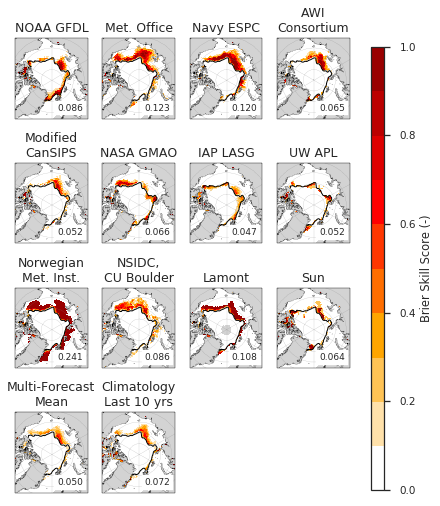

In [18]:
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})
# Set up plotting info
c_label = 'Brier Skill Score (-)'

# New Plot
if cmonth=='August':
    NPLOTS = 15
elif cmonth=='July':
    NPLOTS = 15
else: 
    NPLOTS = 15
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=4, Nplots=NPLOTS, extent=central_extent, central_longitude=0)

for (i, cmod) in enumerate(c_ds.model.values):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    c_BSS = ((c_ds.sel(model=cmod)-obs_sept_SIP)**2)
    p = c_BSS.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)
    
    po = obs_sept_SIP.plot.contour(ax=axes[i], x='xm', y='ym',
                                  transform=ccrs.NorthPolarStereo(central_longitude=-45),
                                  colors=('k'),
                                  linewidths=[1],
                                  levels=[0.5]) #, label='Median ice edge 1981-2010')

    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    axes[i].annotate('{0:.3f}'.format((c_BSS*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)),
                     xy=(.58, .1), backgroundcolor="w",size=9,
                     xycoords='axes fraction', )
    
# MME Mean
i = i + 1
c_BSS = (ds_MME_avg.where(ds_region.mask.isin(ds_region.ocean_regions))-obs_sept_SIP)**2
pmme = c_BSS.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                        transform=ccrs.PlateCarree(),
                        add_colorbar=False, 
                        cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
po = da_obs_SIP.plot.contour(ax=axes[i], x='xm', y='ym',
                          transform=ccrs.NorthPolarStereo(central_longitude=-45),
                          colors=('k'),
                          linewidths=[1],levels=[0.5])

axes[i].set_title('Multi-Forecast\nMean')
axes[i].annotate('{0:.3f}'.format((c_BSS*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)),
                     xy=(.58, .1), backgroundcolor="w",size=9,
                     xycoords='axes fraction', )    





# Climo10yrs
i = i + 1
c_BSS = (climo.where(ds_region.mask.isin(ds_region.ocean_regions))-obs_sept_SIP)**2
pmme = c_BSS.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)

po = da_obs_SIP.plot.contour(ax=axes[i], x='xm', y='ym',
                          transform=ccrs.NorthPolarStereo(central_longitude=-45),
                          colors=('k'),
                          linewidths=[1],levels=[0.5]) 

axes[i].set_title('Climatology\nLast 10 yrs')
axes[i].annotate('{0:.3f}'.format((c_BSS*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)),
                     xy=(.58, .1), backgroundcolor="w",size=9,
                     xycoords='axes fraction', )    

# Make pretty
f.subplots_adjust(bottom=0.05)
cbar_ax = f.add_axes([0.95, 0.075, 0.03, 0.77])
#cbar_ax = f.add_axes([0.14, 0.22, .75, 0.025]) #  [left, bottom, width, height] w
if p:
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='vertical')
#    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
    cbar.set_ticks(np.arange(0,1.1,0.2))
    
# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+'BSS'+'_'+runType+'_'+cyear+'_'+cmonth+'_POSTSEASON.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'panArctic_'+'BSS'+'_'+runType+'_'+cyear+'_'+cmonth+'_lowRES_POSTSEASON.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)

In [21]:
ds_SIP_All=None
cmonth = 'June'
SIP_Jun = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/SIO/'+cyear+'/'+cmonth+'/SIP.nc').SIP
cmonth = 'July'
SIP_Jul = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/SIO/'+cyear+'/'+cmonth+'/SIP.nc').SIP
cmonth = 'August'
SIP_Aug = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/SIO/'+cyear+'/'+cmonth+'/SIP.nc').SIP

months=['June','July','August']

SIP_Jun = SIP_Jun.where(SIP_Jun.isel(model=0).notnull(),other = np.nan)
SIP_Jun = SIP_Jun.where(SIP_Jun.isel(model=0).notnull(),other = np.nan)
SIP_Jun = SIP_Jun.where(SIP_Jun.isel(model=0).notnull(),other = np.nan)

MME_Jun = SIP_Jun.mean(dim='model')
MME_Jul = SIP_Jul.mean(dim='model')
MME_Aug = SIP_Aug.mean(dim='model')

# Mask only to Arctic seas (importand to do this before spatially averaging!)
SIP_Jun = SIP_Jun.where(ds_region.mask.isin(ds_region.ocean_regions))
SIP_Jul = SIP_Jul.where(ds_region.mask.isin(ds_region.ocean_regions))
SIP_Aug = SIP_Aug.where(ds_region.mask.isin(ds_region.ocean_regions))

In [136]:
# FIRST ONLY CONSIDER COMMON MODELS
common_models = [x for x in SIP_Aug.model.values if x in SIP_Jun.model.values] 
common_models = [x for x in common_models if x in SIP_Jul.model.values] 
common_models = common_models+['MME']
common_models
BSS=np.zeros((len(common_models),3))
for (i, cmod) in enumerate(common_models):
    if cmod=='MME':
        BSS[i,0] = (((SIP_Jun.sel(model=common_models[:-1]).mean(dim='model')-obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)
        BSS[i,1] = (((SIP_Jul.sel(model=common_models[:-1]).mean(dim='model')-obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)
        BSS[i,2] = (((SIP_Aug.sel(model=common_models[:-1]).mean(dim='model')-obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)
    else:
        BSS[i,0] = (((SIP_Jun.sel(model=cmod)-obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)
        BSS[i,1] = (((SIP_Jul.sel(model=cmod)-obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)
        BSS[i,2] = (((SIP_Aug.sel(model=cmod)-obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)
BSS = xr.DataArray(BSS, coords=[common_models,months], dims=['model','months'])

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  

In [128]:
BSS

<xarray.DataArray (model: 14, months: 3)>
array([[     nan, 0.060732, 0.067342],
       [0.107795, 0.165774, 0.131805],
       [0.064684, 0.06237 , 0.049593],
       [0.046564, 0.038588, 0.051531],
       [0.085938, 0.075638, 0.115632],
       [0.065814, 0.08336 , 0.123608],
       [0.051865, 0.058265, 0.06761 ],
       [0.064407, 0.079962, 0.05683 ],
       [0.240696,      nan,      nan],
       [0.051702, 0.089698, 0.059687],
       [0.085898, 0.054972, 0.038472],
       [0.122856, 0.060717, 0.035187],
       [0.120376, 0.070448, 0.100759],
       [0.049523, 0.042622, 0.034094]])
Coordinates:
  * model    (model) object 'RASM' 'Xiaojun' 'awispin' ... 'usnavysipn' 'MME'
  * months   (months) <U6 'June' 'July' 'August'

saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/SIO_Reports/2019/August/panArctic_Mean_BSS_Summary2019_POSTSEASON_lowRes.png


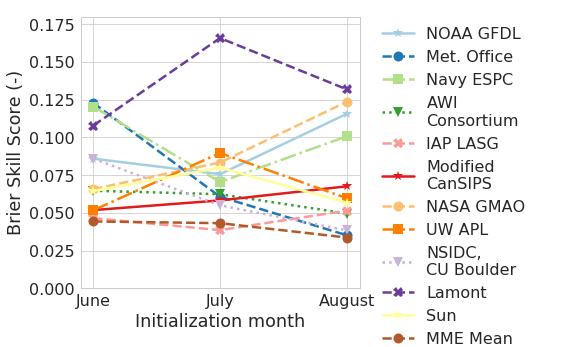

In [130]:
# Define colors/lines etce for each model to use in plots
cmap_c = itertools.cycle(sns.color_palette("Paired", len(common_models) ))
linecycler = itertools.cycle(["-","--","-.",":","--"])
markercycler = itertools.cycle(["*","o","s","v","X"])
mod_cc = {}
mod_ls = {}
mod_mk = {}
for (i, cmod) in enumerate(common_models):
    mod_cc[cmod] = next(cmap_c)
    mod_ls[cmod] = next(linecycler)
    mod_mk[cmod] = next(markercycler)

# Plot for June, July, August, the mean BSS scores
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
sns.set_style('whitegrid')
(f,ax) = plt.subplots(1,1)
f.set_size_inches((5,5))
for (i, cmod) in enumerate(common_models):
    ax.plot(months, BSS.sel(model=cmod).values, 
            color=mod_cc[cmod],
            marker=mod_mk[cmod],
            linestyle=mod_ls[cmod],
            markersize=10,
            label=get_plot_title(cmod, custom_names, E))
f.legend(loc='lower right', bbox_to_anchor=(1.5, -0.04))
ax.set_ylim([0,0.18])
ax.set_ylabel('Brier Skill Score (-)')
ax.set_xlabel('Initialization month')

# Save to file
fig_dir = os.path.join(E.fig_dir, 'model', 'SIO_Reports', cyear, 'August')
f_out = os.path.join(fig_dir,'panArctic_Mean_BSS_Summary'+cyear+'_POSTSEASON.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'panArctic_Mean_BSS_Summary'+cyear+'_POSTSEASON_lowRes.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)


In [137]:
list1 = SIP_Jun.model.values
list2 = SIP_Jul.model.values
all_models = np.append(SIP_Jun.model.values,SIP_Jul.model.values)
all_models = np.append(all_models,SIP_Aug.model.values)
all_models = np.unique(all_models)
all_models
common_models = np.append(all_models,'MME')
BSS=np.zeros((len(common_models),3))
BSS[:] = np.nan
for (i, cmod) in enumerate(common_models):
    if cmod=='MME':
        BSS[i,0] = (((SIP_Jun.mean(dim='model')-obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)
        BSS[i,1] = (((SIP_Jul.mean(dim='model')-obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)
        BSS[i,2] = (((SIP_Aug.mean(dim='model')-obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)
    else:
        if cmod in SIP_Jun.model:
            BSS[i,0] = (((SIP_Jun.sel(model=cmod)-obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)
        if cmod in SIP_Jul.model:
            BSS[i,1] = (((SIP_Jul.sel(model=cmod)-obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)
        if cmod in SIP_Aug.model:
            BSS[i,2] = (((SIP_Aug.sel(model=cmod)-obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)
BSS = xr.DataArray(BSS, coords=[common_models,months], dims=['model','months'])

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  

saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/SIO_Reports/2019/August/panArctic_Mean_BSS_Summary2019_POSTSEASON_lowRes_opt2.png


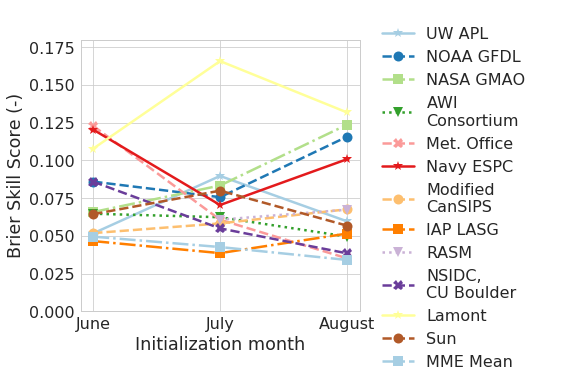

In [152]:
# norwegian model is awful and it is only in jun so leave off
# reorder this way
these_models=['piomas','gfdlsipn', 'gmao','awispin','ukmetofficesipn', 'usnavysipn',
       'modcansipns_4', 'fgoalssipn','RASM','seansipn','Xiaojun','nicosipn','MME']

# Define colors/lines etce for each model to use in plots
cmap_c = itertools.cycle(sns.color_palette("Paired", len(common_models) ))
linecycler = itertools.cycle(["-","--","-.",":","--"])
markercycler = itertools.cycle(["*","o","s","v","X"])
mod_cc = {}
mod_ls = {}
mod_mk = {}
for (i, cmod) in enumerate(these_models):
    mod_cc[cmod] = next(cmap_c)
    mod_ls[cmod] = next(linecycler)
    mod_mk[cmod] = next(markercycler)

# Plot for June, July, August, the mean BSS scores
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
sns.set_style('whitegrid')
(f,ax) = plt.subplots(1,1)
f.set_size_inches((5,5))
for (i, cmod) in enumerate(these_models):
    ax.plot(months, BSS.sel(model=cmod).values, 
            color=mod_cc[cmod],
            marker=mod_mk[cmod],
            linestyle=mod_ls[cmod],
            markersize=10,
            label=get_plot_title(cmod, custom_names, E))

f.legend(loc='lower right', bbox_to_anchor=(1.5, -0.04))
ax.set_ylim([0,0.18])
ax.set_ylabel('Brier Skill Score (-)')
ax.set_xlabel('Initialization month')

# Save to file
fig_dir = os.path.join(E.fig_dir, 'model', 'SIO_Reports', cyear, 'August')
f_out = os.path.join(fig_dir,'panArctic_Mean_BSS_Summary'+cyear+'_POSTSEASON_opt2.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'panArctic_Mean_BSS_Summary'+cyear+'_POSTSEASON_lowRes_opt2.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)


